In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis


import sys
sys.path.append('/home/josea/DEEP_TIMING/DEEP_TIMING_VS/')

In [2]:
from functions import (continuous_delay, create_position, calculate_gaussian_center_sigma, 
                       extract_signal_window_by_fraction, plot_gaussian, get_gaussian_params)

In [3]:
# Load data 
dir = '/home/josea/DEEP_TIMING/DEEP_TIMING_VS/Na22_filtered_data/'

data = np.load(os.path.join(dir, 'Na22_test_val.npz'))['data']

In [4]:
# -------------------------------------------------------------------------
#----------------------- IMPORTANT DEFINITIONS ----------------------------
# -------------------------------------------------------------------------
time_step = 0.2         # Signal time step in ns
nbins = 71              # Num bins for all histograms                   
t_shift = 1             # Time steps to move for the new positions
Num_train = 500
Num_test = data.shape[0] - Num_train

In [5]:
# -------------------------------------------------------------------------
#----------------------- ALIGN PULSES -------------------------------
# -------------------------------------------------------------------------
align_time = 0.6
new_data = continuous_delay(data, time_step = time_step, delay_time = align_time, channel_to_fix = 0, channel_to_move = 1)


# **NN MODEL PREDICTIONS**

In [6]:
# Load model predictions
pred_dec0 = np.load('/home/josea/DEEP_TIMING/DEEP_TIMING_VS/predictions/test_dec0_Na22.npz', allow_pickle = True)['data']
pred_dec1 = np.load('/home/josea/DEEP_TIMING/DEEP_TIMING_VS/predictions/test_dec1_Na22.npz', allow_pickle = True)['data']


# Calculate NN TOF and extract the different positions
TOF = pred_dec0[-1,:] - pred_dec1[-1,:]

TOF_V02 = TOF[:new_data.shape[0]] 
TOF_V00 = TOF[new_data.shape[0] : 2*new_data.shape[0]] 
TOF_V20 = TOF[2*new_data.shape[0] :3*new_data.shape[0]] 
TOF_V04 = TOF[3*new_data.shape[0] :4*new_data.shape[0]] 
TOF_V40 = TOF[4*new_data.shape[0]:] 


# Calculate errors
centroid_V00, sigmaN_V00 = calculate_gaussian_center_sigma(TOF_V00[None, :], np.zeros((TOF_V00[None, :].shape[0])), nbins = nbins) 

error_V02 = (TOF_V02 - centroid_V00 + time_step*t_shift)
error_V00 = (TOF_V00 - centroid_V00)
error_V20 = (TOF_V20 - centroid_V00 - time_step*t_shift)
error_V04 = (TOF_V04 - centroid_V00 + 2*time_step*t_shift)
error_V40 = (TOF_V40 - centroid_V00 - 2*time_step*t_shift)


# Train/test target split
Error_train = np.concatenate((error_V02[:Num_train], error_V20[:Num_train], error_V00[:Num_train], error_V04[:Num_train], error_V40[:Num_train]))
Error_test = np.concatenate((error_V02[Num_train:], error_V20[Num_train:], error_V00[Num_train:], error_V04[Num_train:], error_V40[Num_train:]))

# **PYCARET CORRECTION**

In [7]:
# Eliminate time dependencies by getting signals by a fixed fraction
new_data = extract_signal_window_by_fraction(new_data, fraction = 0.05, window_low = 10, window_high = 7)

# Create the other positions for train and test
POS_00 = new_data
POS_02 = create_position(POS_00, channel_to_move = 1, channel_to_fix = 0, t_shift = t_shift)
POS_20 = create_position(POS_00, channel_to_move = 0, channel_to_fix = 1, t_shift = t_shift)
POS_04 = create_position(POS_00, channel_to_move = 1, channel_to_fix = 0, t_shift = int(2*t_shift))
POS_40 = create_position(POS_00, channel_to_move = 0, channel_to_fix = 1, t_shift = int(2*t_shift))


TRAIN = np.concatenate((POS_02[:Num_train], POS_00[:Num_train], POS_20[:Num_train], POS_04[:Num_train], POS_40[:Num_train]), axis = 0)
TEST  = np.concatenate((POS_02[Num_train:], POS_00[Num_train:], POS_20[Num_train:], POS_04[Num_train:], POS_40[Num_train:]), axis = 0)

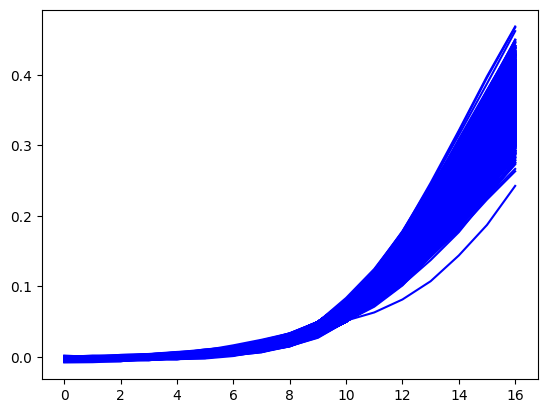

In [8]:
for i in range(POS_00.shape[0]):
    plt.plot(POS_00[i,:,0], 'b-')

In [9]:
# Get train/test time independent parameters
mean_train = np.mean(TRAIN, axis = 1)
variance_train = np.var(TRAIN, axis = 1)
skewness_train = skew(TRAIN, axis = 1)
kurtosis_train = kurtosis(TRAIN, axis = 1)

mean_test = np.mean(TEST, axis = 1)
variance_test = np.var(TEST, axis = 1)
skewness_test = skew(TEST, axis = 1)
kurtosis_test = kurtosis(TEST, axis = 1)


# Concatenate the train/test features
features_train = np.stack((mean_train[:,0], variance_train[:,0], skewness_train[:,0], kurtosis_train[:,0], 
                           mean_train[:,1], variance_train[:,1], skewness_train[:,1], kurtosis_train[:,1]), axis = 1)

features_test = np.stack((mean_test[:,0], variance_test[:,0], skewness_test[:,0], kurtosis_test[:,0], 
                          mean_test[:,1], variance_test[:,1], skewness_test[:,1], kurtosis_test[:,1]), axis = 1)

In [10]:
# Save to a DataFrame 
features_train_df = pd.DataFrame(features_train, columns = ['Mean_dec0', 'Variance_dec0', 'Skewness_dec0', 'Kurtosis_dec0',
                                                            'Mean_dec1', 'Variance_dec1', 'Skewness_dec1', 'Kurtosis_dec1'])

features_test_df = pd.DataFrame(features_test, columns = ['Mean_dec0', 'Variance_dec0', 'Skewness_dec0', 'Kurtosis_dec0',
                                                          'Mean_dec1', 'Variance_dec1', 'Skewness_dec1', 'Kurtosis_dec1'])

In [11]:
from pycaret.regression import *
s = setup(features_train_df, target = Error_train,  session_id = 123, normalize = True, normalize_method = 'zscore')

,Description,Value
0,Session id,123
1,Target,target
2,Target type,Regression
3,Original data shape,"(2500, 9)"
4,Transformed data shape,"(2500, 9)"
5,Transformed train set shape,"(1750, 9)"
6,Transformed test set shape,"(750, 9)"
7,Numeric features,8
8,Preprocess,True
9,Imputation type,simple


In [12]:
model = compare_models('')
print(model)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,0.0590,0.0065,0.0801,0.3031,0.0000,2.2203,0.0340
et,Extra Trees Regressor,0.0587,0.0067,0.0812,0.2848,0.0000,2.1397,0.0150
gbr,Gradient Boosting Regressor,0.0625,0.0067,0.0817,0.2664,0.0000,2.0534,0.0320
ridge,Ridge Regression,0.0670,0.0080,0.0888,0.1434,0.0000,1.9313,0.0780
lr,Linear Regression,0.0670,0.0080,0.0889,0.1428,0.0000,1.9554,0.1280
br,Bayesian Ridge,0.0670,0.0080,0.0889,0.1425,0.0000,1.9088,0.0040
huber,Huber Regressor,0.0669,0.0080,0.0889,0.1408,0.0000,1.9232,0.0040
lar,Least Angle Regression,0.0684,0.0083,0.0907,0.1061,0.0000,2.1638,0.0020
ada,AdaBoost Regressor,0.0703,0.0084,0.0917,0.0854,0.0000,2.0697,0.0120
omp,Orthogonal Matching Pursuit,0.0729,0.0092,0.0955,0.0105,0.0000,1.5826,0.0030


RandomForestRegressor(n_jobs=-1, random_state=123)


In [13]:
# Get more detailed model evaluations
evaluate_model(model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

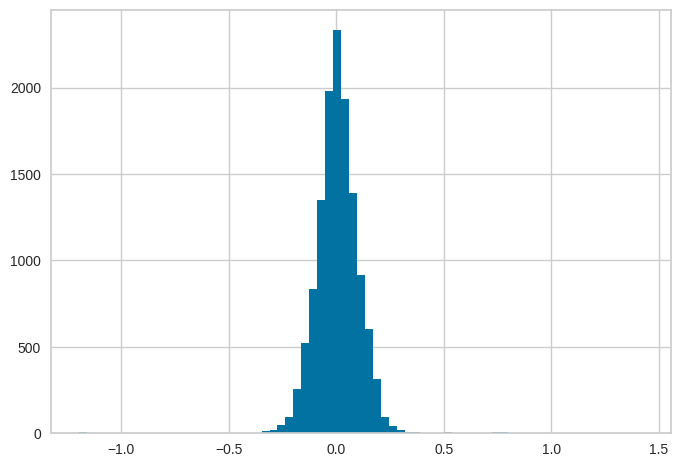

In [14]:
predictions_ML = predict_model(model, data = features_test_df)

Error_pred = predictions_ML['prediction_label'].to_numpy() - Error_test
plt.hist(Error_pred, bins = nbins);

In [15]:
# Get test set predictions
predictions = predictions_ML['prediction_label'].to_numpy()

predictions_V02 = predictions[:Num_test] 
predictions_V00 = predictions[Num_test : 2*Num_test]
predictions_V20 = predictions[2*Num_test :3*Num_test]
predictions_V04 = predictions[3*Num_test :4*Num_test]
predictions_V40 = predictions[4*Num_test:] 

# Correct test set TOF
TOF_V02_corr = TOF_V02[Num_train:]  - predictions_V02
TOF_V00_corr = TOF_V00[Num_train:]  - predictions_V00
TOF_V20_corr = TOF_V20[Num_train:]  - predictions_V20
TOF_V04_corr = TOF_V04[Num_train:]  - predictions_V04
TOF_V40_corr = TOF_V40[Num_train:]  - predictions_V40

V40: CENTROID(ns) = 0.4015 +/- 0.00157  FWHM(ns) = 0.1880 +/- 0.00167
V20: CENTROID(ns) = 0.1946 +/- 0.00097  FWHM(ns) = 0.1965 +/- 0.00103
V00: CENTROID(ns) = -0.0001 +/- 0.00167  FWHM(ns) = 0.1942 +/- 0.00177
V02: CENTROID(ns) = -0.1980 +/- 0.00113  FWHM(ns) = 0.2042 +/- 0.00120
V04: CENTROID(ns) = -0.4004 +/- 0.00151  FWHM(ns) = 0.2033 +/- 0.00161



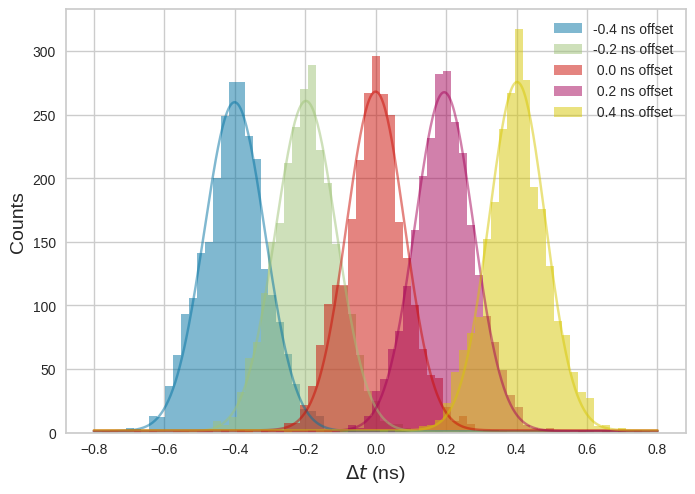

In [16]:
centroid_V00, sigmaN_V00 = calculate_gaussian_center_sigma(TOF_V00_corr[None, :], np.zeros((TOF_V00_corr[None, :].shape[0])), nbins = nbins) 


# Histogram and gaussian fit
plot_gaussian(TOF_V04_corr, centroid_V00, range = 0.8, label = '-0.4 ns offset', nbins = nbins)
plot_gaussian(TOF_V02_corr, centroid_V00, range = 0.8, label = '-0.2 ns offset', nbins = nbins)
plot_gaussian(TOF_V00_corr, centroid_V00, range = 0.8, label = ' 0.0 ns offset', nbins = nbins)
plot_gaussian(TOF_V20_corr, centroid_V00, range = 0.8, label = ' 0.2 ns offset', nbins = nbins)
plot_gaussian(TOF_V40_corr, centroid_V00, range = 0.8, label = ' 0.4 ns offset', nbins = nbins)


params_V04, errors_V04 = get_gaussian_params(TOF_V04_corr, centroid_V00, range = 0.8, nbins = nbins)
params_V02, errors_V02 = get_gaussian_params(TOF_V02_corr, centroid_V00, range = 0.8, nbins = nbins)
params_V00, errors_V00 = get_gaussian_params(TOF_V00_corr, centroid_V00, range = 0.8, nbins = nbins)
params_V20, errors_V20 = get_gaussian_params(TOF_V20_corr, centroid_V00, range = 0.8, nbins = nbins)
params_V40, errors_V40 = get_gaussian_params(TOF_V40_corr, centroid_V00, range = 0.8, nbins = nbins)


print("V40: CENTROID(ns) = %.4f +/- %.5f  FWHM(ns) = %.4f +/- %.5f" % (params_V40[2], errors_V40[2], params_V40[3], errors_V40[3]))
print("V20: CENTROID(ns) = %.4f +/- %.5f  FWHM(ns) = %.4f +/- %.5f" % (params_V20[2], errors_V20[2], params_V20[3], errors_V20[3]))
print("V00: CENTROID(ns) = %.4f +/- %.5f  FWHM(ns) = %.4f +/- %.5f" % (params_V00[2], errors_V00[2], params_V00[3], errors_V00[3]))
print("V02: CENTROID(ns) = %.4f +/- %.5f  FWHM(ns) = %.4f +/- %.5f" % (params_V02[2], errors_V02[2], params_V02[3], errors_V02[3]))
print("V04: CENTROID(ns) = %.4f +/- %.5f  FWHM(ns) = %.4f +/- %.5f" % (params_V04[2], errors_V04[2], params_V04[3], errors_V04[3]))

print('')
plt.legend()
plt.xlabel('$\Delta t$ (ns)', fontsize = 14)
plt.ylabel('Counts', fontsize = 14)
plt.show()


# **NN Approach**

In [17]:
import numpy as np
import torch
import torch.optim as optim
from functions import set_seed
from Models import MLP_Torch

set_seed(42)

In [18]:
Error_train = Error_train.astype(np.float32)
Error_test = Error_test.astype(np.float32)

In [20]:
train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(features_train).float(), torch.from_numpy(np.expand_dims(Error_train, axis = -1)).float())
val_dataset = torch.utils.data.TensorDataset(torch.from_numpy(features_test).float(), torch.from_numpy(np.expand_dims(Error_test, axis = -1)).float())


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 32, shuffle = True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = 64, shuffle = False)

In [21]:
def train_loop_MLP(model, optimizer,  train_loader, val_loader, test_tensor, EPOCHS = 75, name = 'model', save = False):

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    test_tensor = test_tensor.to(device)
    
    
    loss_list = []
    val_loss_list = []
    test = []

    # Cosine Annealing Scheduler
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = EPOCHS)

    for epoch in range(EPOCHS):
        running_loss = 0.0
        avg_loss_epoch = 0.0
        model.train()
        for i, data in enumerate(train_loader):
            # Every data instance is an input + label pair
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero your gradients for every batch
            optimizer.zero_grad()

            # Make predictions for this batch for both channels
            outputs= model(inputs)

            # Compute the loss and its gradients
            loss = torch.mean((outputs - labels)**2)
            loss.backward()

            # Adjust learning weights
            optimizer.step()
            
            # Accumulate running loss
            running_loss += loss.item()

        # Step the scheduler
        scheduler.step()

        # Calculate average loss per epoch
        avg_loss_epoch = running_loss / int(i)  # loss per batch
        loss_list.append(avg_loss_epoch)

        print('EPOCH {}:'.format(epoch + 1))
        print('LOSS train {}'.format(avg_loss_epoch))

        # Calculate predictions on test_tensor
        model.eval()
        with torch.no_grad():
            test_epoch = model(test_tensor)
            test.append(np.squeeze(test_epoch.cpu().numpy()))

            val_loss = 0
            for val_data, val_labels in val_loader:
                val_data, val_labels = val_data.to(device), val_labels.to(device)
                val = model(val_data)
                val_loss += torch.mean(abs(val - val_labels))
            val_loss_list.append(val_loss.cpu().numpy() / len(val_loader))
            print(f'LOSS val {val_loss / len(val_loader)}')


    # Save the model at the specified checkpoint frequency if 'save' is True
    if save:
       torch.save(model.state_dict(), name)

    

    return np.array(loss_list, dtype = 'object'), np.array(val_loss_list, dtype = 'object'), np.array(test, dtype = 'object')


In [22]:
epochs = 500
model = MLP_Torch(NM = 8, NN = 32, STD_INIT = 0.5)
optimizer = torch.optim.AdamW(model.parameters(), lr = 5e-4)  

loss, val_loss, test = train_loop_MLP(model, optimizer, train_loader, val_loader, torch.tensor(features_test).float(), EPOCHS = epochs) 

EPOCH 1:
LOSS train 13.899217170018416
LOSS val 1.2268379926681519
EPOCH 2:
LOSS train 1.147469754020373
LOSS val 0.4565112292766571
EPOCH 3:
LOSS train 0.24377059315641722
LOSS val 0.30102211236953735
EPOCH 4:
LOSS train 0.13626784129211536
LOSS val 0.250060111284256
EPOCH 5:
LOSS train 0.09387588099791454
LOSS val 0.2107471078634262
EPOCH 6:
LOSS train 0.06584070739933313
LOSS val 0.17688490450382233
EPOCH 7:
LOSS train 0.04908426062991986
LOSS val 0.16182565689086914
EPOCH 8:
LOSS train 0.040814344448825486
LOSS val 0.15200643241405487
EPOCH 9:
LOSS train 0.035304884474055886
LOSS val 0.14226576685905457
EPOCH 10:
LOSS train 0.031454761166316576
LOSS val 0.13623657822608948
EPOCH 11:
LOSS train 0.02877886298423012
LOSS val 0.131125345826149
EPOCH 12:
LOSS train 0.026954873632162046
LOSS val 0.12632426619529724
EPOCH 13:
LOSS train 0.02545821352694661
LOSS val 0.12338007241487503
EPOCH 14:
LOSS train 0.02375733385531184
LOSS val 0.12050019204616547
EPOCH 15:
LOSS train 0.022909727604

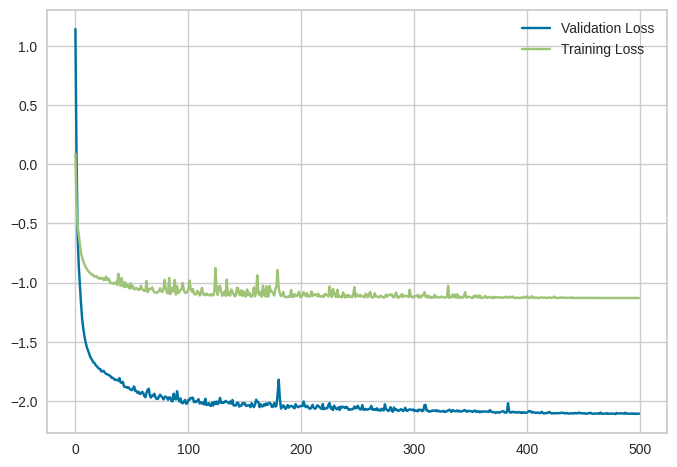

In [23]:
plt.plot(np.log10(loss.astype(np.float64)), label = 'Validation Loss')
plt.plot(np.log10(val_loss.astype(np.float64)), label = 'Training Loss')
plt.legend()

In [24]:
# Get test set predictions
predictions = test[-1, :]

predictions_V02 = predictions[:Num_test] 
predictions_V00 = predictions[Num_test : 2*Num_test]
predictions_V20 = predictions[2*Num_test :3*Num_test]
predictions_V04 = predictions[3*Num_test :4*Num_test]
predictions_V40 = predictions[4*Num_test:] 

# Correct test set TOF
TOF_V02_corr = TOF_V02[Num_train:]  - predictions_V02
TOF_V00_corr = TOF_V00[Num_train:]  - predictions_V00
TOF_V20_corr = TOF_V20[Num_train:]  - predictions_V20
TOF_V04_corr = TOF_V04[Num_train:]  - predictions_V04
TOF_V40_corr = TOF_V40[Num_train:]  - predictions_V40

V40: CENTROID(ns) = 0.4059 +/- 0.00070  FWHM(ns) = 0.1960 +/- 0.00074
V20: CENTROID(ns) = 0.2003 +/- 0.00097  FWHM(ns) = 0.1949 +/- 0.00103
V00: CENTROID(ns) = -0.0009 +/- 0.00106  FWHM(ns) = 0.1930 +/- 0.00113
V02: CENTROID(ns) = -0.2001 +/- 0.00147  FWHM(ns) = 0.1960 +/- 0.00156
V04: CENTROID(ns) = -0.3987 +/- 0.00094  FWHM(ns) = 0.2031 +/- 0.00100



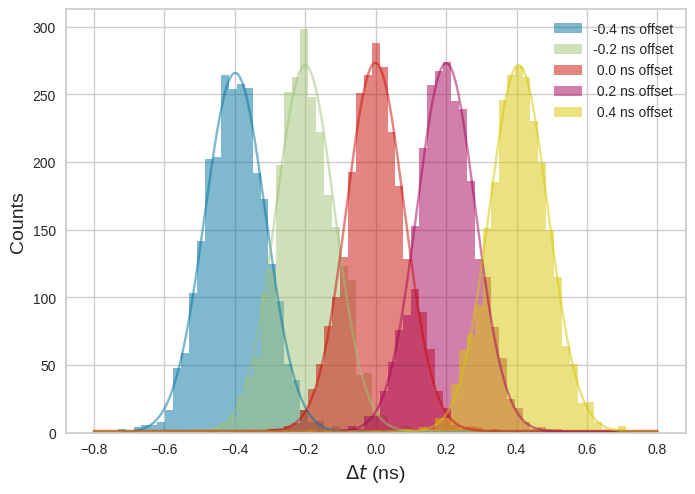

In [25]:
centroid_V00, sigmaN_V00 = calculate_gaussian_center_sigma(TOF_V00_corr[None, :], np.zeros((TOF_V00_corr[None, :].shape[0])), nbins = nbins) 


# Histogram and gaussian fit
plot_gaussian(TOF_V04_corr, centroid_V00, range = 0.8, label = '-0.4 ns offset', nbins = nbins)
plot_gaussian(TOF_V02_corr, centroid_V00, range = 0.8, label = '-0.2 ns offset', nbins = nbins)
plot_gaussian(TOF_V00_corr, centroid_V00, range = 0.8, label = ' 0.0 ns offset', nbins = nbins)
plot_gaussian(TOF_V20_corr, centroid_V00, range = 0.8, label = ' 0.2 ns offset', nbins = nbins)
plot_gaussian(TOF_V40_corr, centroid_V00, range = 0.8, label = ' 0.4 ns offset', nbins = nbins)


params_V04, errors_V04 = get_gaussian_params(TOF_V04_corr, centroid_V00, range = 0.8, nbins = nbins)
params_V02, errors_V02 = get_gaussian_params(TOF_V02_corr, centroid_V00, range = 0.8, nbins = nbins)
params_V00, errors_V00 = get_gaussian_params(TOF_V00_corr, centroid_V00, range = 0.8, nbins = nbins)
params_V20, errors_V20 = get_gaussian_params(TOF_V20_corr, centroid_V00, range = 0.8, nbins = nbins)
params_V40, errors_V40 = get_gaussian_params(TOF_V40_corr, centroid_V00, range = 0.8, nbins = nbins)


print("V40: CENTROID(ns) = %.4f +/- %.5f  FWHM(ns) = %.4f +/- %.5f" % (params_V40[2], errors_V40[2], params_V40[3], errors_V40[3]))
print("V20: CENTROID(ns) = %.4f +/- %.5f  FWHM(ns) = %.4f +/- %.5f" % (params_V20[2], errors_V20[2], params_V20[3], errors_V20[3]))
print("V00: CENTROID(ns) = %.4f +/- %.5f  FWHM(ns) = %.4f +/- %.5f" % (params_V00[2], errors_V00[2], params_V00[3], errors_V00[3]))
print("V02: CENTROID(ns) = %.4f +/- %.5f  FWHM(ns) = %.4f +/- %.5f" % (params_V02[2], errors_V02[2], params_V02[3], errors_V02[3]))
print("V04: CENTROID(ns) = %.4f +/- %.5f  FWHM(ns) = %.4f +/- %.5f" % (params_V04[2], errors_V04[2], params_V04[3], errors_V04[3]))


print('')
plt.legend()
plt.xlabel('$\Delta t$ (ns)', fontsize = 14)
plt.ylabel('Counts', fontsize = 14)
plt.show()

(12875,)


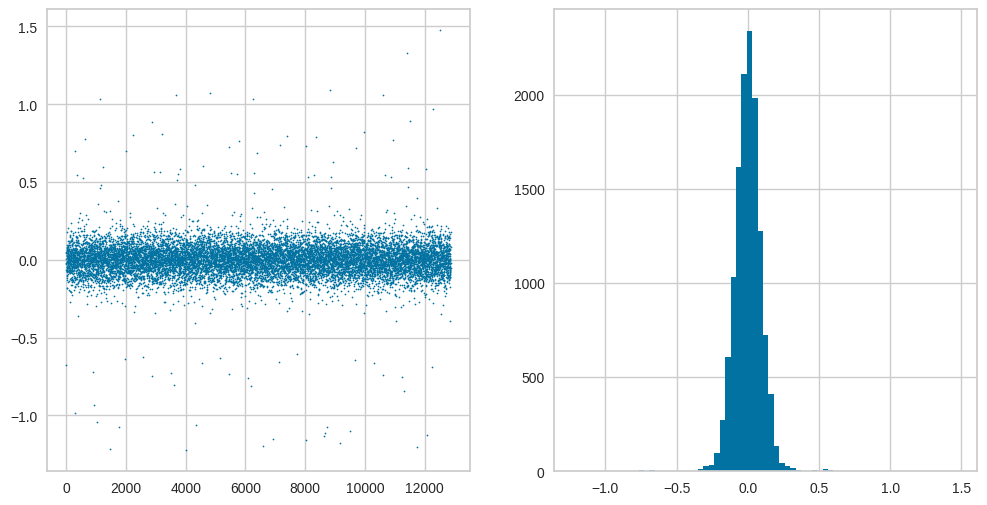

In [26]:
# Caculate residuals
residuals = predictions - Error_test
a = np.where(residuals < 2)
plt.figure(figsize = (12, 6))
plt.subplot(121)
plt.plot(residuals[a], 'b.', markersize = 2.5)
plt.subplot(122)
plt.hist(residuals[a], bins = nbins)
print(residuals.shape)